<a href="https://colab.research.google.com/github/mgnarag/Generative-AI/blob/main/Reflectance_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!ls drive/My\ Drive
file_path = "/content/drive/MyDrive/Baumgartner screenshots/Reflectance_estimation/"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from scipy.io import loadmat

[[ 2.39346316 -2.02054944  1.01792283]
 [ 2.42267284  0.5259467  -1.1345829 ]
 [ 1.05518184  1.83733835  1.35594432]]
[[ 86610.40820657]
 [-14912.33396422]
 [ 12492.03154485]]
a shape (3, 1)
eigen shape (3, 61)


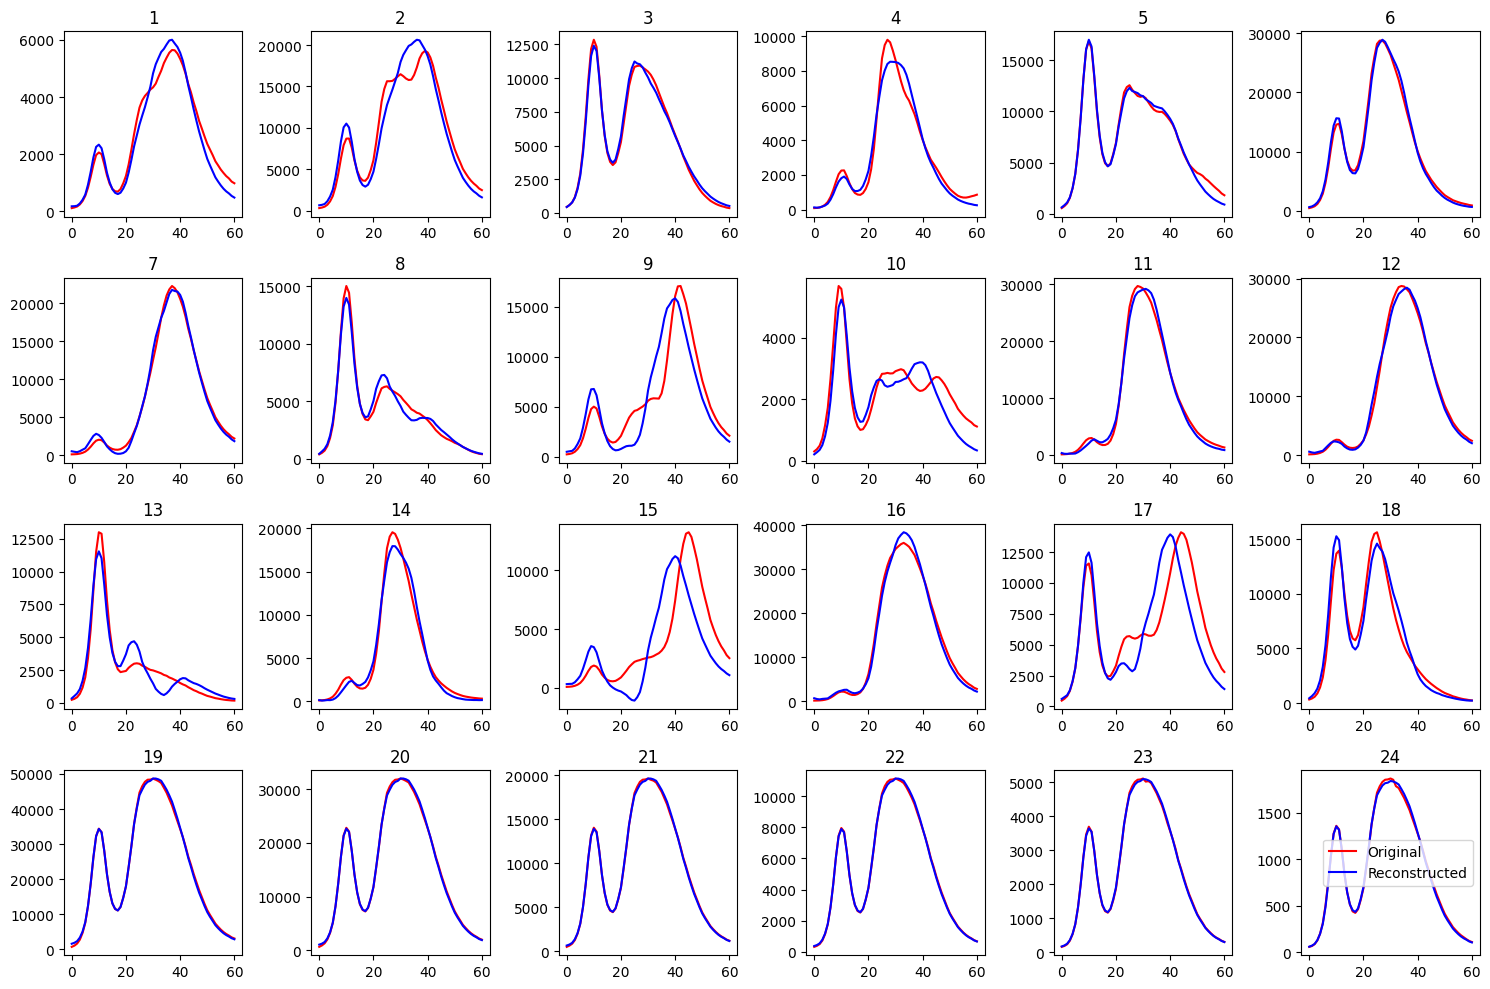

In [ ]:
# Step 1a: Reading the light source and Munsell
P_lambda = pd.read_excel(file_path+'LED_Array_3.xls', header=None).values
Lamda = np.arange(400, 705, 5)
interp_func = interp1d(P_lambda[:,0], P_lambda[:,1], fill_value="extrapolate")
P_lambda = interp_func(Lamda)

# Load Munsell reflectance data
munsell_data = loadmat(file_path+'munsell400_700_5.mat')
R_lambda = munsell_data['munsell']

# Step 2: Interpolate each column of R_lambda
interp_R_lambda = np.zeros((len(Lamda), R_lambda.shape[1]))  # Initialize the interpolated matrix

for i in range(R_lambda.shape[1]):
    interp_func = interp1d(np.arange(400, 705, 5), R_lambda[:, i], fill_value="extrapolate")  # Original data has 5 nm intervals
    interp_R_lambda[:, i] = interp_func(Lamda)  # Interpolate to the 1 nm interval

R_lambda = interp_R_lambda

# Step 1b: Getting the color signal
C_lambda = P_lambda[:, np.newaxis] * R_lambda


# Step 2: Computing eigenspectra of ensemble color signals
pca = PCA(n_components=3)
pca.fit(C_lambda.T)
eigen = pca.components_  # Get the first principal component


# Step 3: Computing transformation matrix T
data = np.loadtxt(file_path+'camera_8_spectra.txt')
Lambda_raw = data[:, 0]
S_R_raw = data[:, 1]
S_G_raw = data[:, 2]
S_B_raw = data[:, 3]

S_R = interp1d(Lambda_raw, S_R_raw, fill_value="extrapolate")(Lamda)
S_G = interp1d(Lambda_raw, S_G_raw, fill_value="extrapolate")(Lamda)
S_B = interp1d(Lambda_raw, S_B_raw, fill_value="extrapolate")(Lamda)
S_rgb = np.vstack((S_R, S_G, S_B)).T
T = S_rgb.T@ eigen.T
print(T)

# Step 4: Getting values of q
R_lambda_macbeth = pd.read_excel(file_path+'MacbethColorChecker.xlsx', header=None).values
range_mask = (R_lambda_macbeth[:, 0] > 399) & (R_lambda_macbeth[:, 0] < 701)
R_lambda_macbeth = R_lambda_macbeth[range_mask, :]

# Step 2: Interpolate each column of R_lambda
interp_R_lambda = np.zeros((len(Lamda), R_lambda_macbeth.shape[1]))  # Initialize the interpolated matrix

for i in range(R_lambda_macbeth.shape[1]):
    interp_func = interp1d(np.arange(400, 705, 5), R_lambda_macbeth[:, i], fill_value="extrapolate")  # Original data has 5 nm intervals
    interp_R_lambda[:, i] = interp_func(Lamda)  # Interpolate to the 1 nm interval

R_lambda_macbeth = interp_R_lambda


q_r, q_g, q_b = [], [], []

for i in range(1, 25):  # Index of Macbeth patches starts at i=2
    PRS_red = P_lambda * R_lambda_macbeth[:, i] * S_R
    q_r.append(np.sum(PRS_red))
    PRS_green = P_lambda * R_lambda_macbeth[:, i] * S_G
    q_g.append(np.sum(PRS_green))
    PRS_blue = P_lambda * R_lambda_macbeth[:, i] * S_B
    q_b.append(np.sum(PRS_blue))

# Applying the Wiener estimation
patch = 1
C1 = np.linalg.inv(T.T @ T)
C2 = C1 @ T.T
q = np.vstack((q_r[patch], q_g[patch], q_b[patch]))
a = C2 @ q
print(a)
print("a shape", a.shape)
print("eigen shape", eigen.shape)


# For all patches
fig, axs = plt.subplots(4, 6, figsize=(15, 10))
for patch in range(24):
    C1 = np.linalg.inv(T.T @ T)
    C2 = C1 @ T.T
    q = np.vstack((q_r[patch], q_g[patch], q_b[patch]))
    a = C2 @ q
    color_spectra_macbeth = P_lambda * R_lambda_macbeth[:, patch + 1]
    C3 = eigen.T @ a

    axs[patch // 6, patch % 6].plot(color_spectra_macbeth, '-r', label='Original')
    axs[patch // 6, patch % 6].plot(C3, '-b', label='Reconstructed')
    axs[patch // 6, patch % 6].set_title(patch + 1)

plt.tight_layout()
plt.legend()
plt.show()


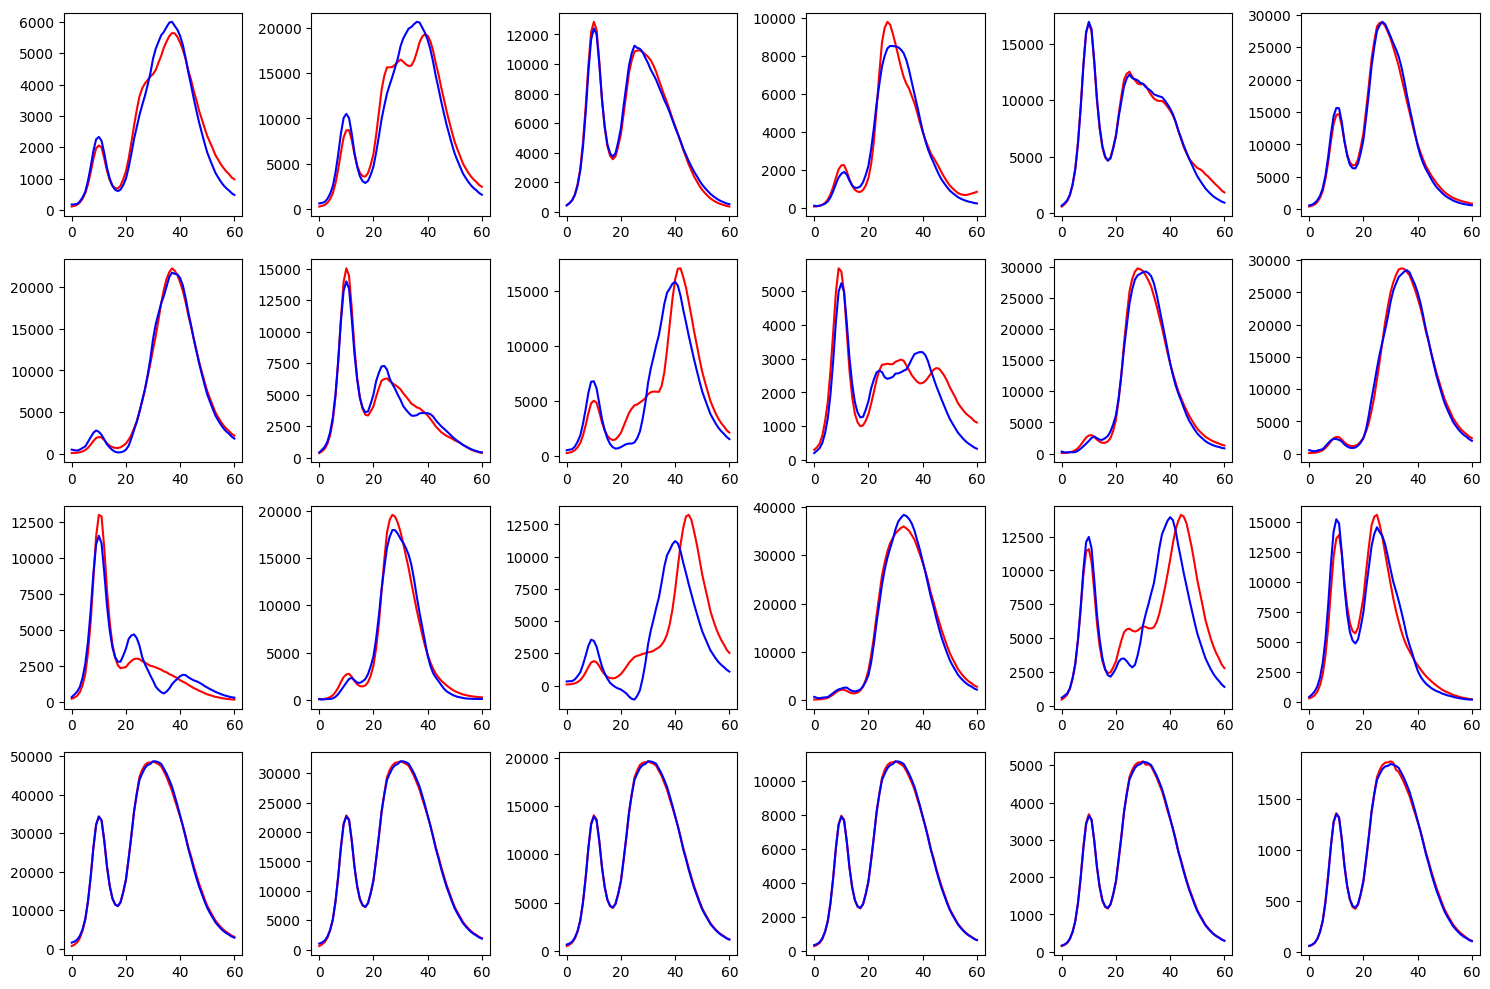

In [ ]:
# For all patches
fig, axs = plt.subplots(4, 6, figsize=(15, 10))
for patch in range(24):
    C1 = np.linalg.inv(T.T @ T)
    C2 = C1 @ T.T
    q = np.vstack((q_r[patch], q_g[patch], q_b[patch]))
    a = C2 @ q
    C3 = eigen.T @ a

    color_spectra_macbeth = P_lambda * R_lambda_macbeth[:, patch + 1]


    PRS_red = np.sum(C3[:,0]*S_R)
    PRS_green = np.sum(C3[:,0]*S_G)
    PRS_blue = np.sum(C3[:,0]*S_B)

    PS_red = np.sum(P_lambda*S_R)
    PS_green = np.sum(P_lambda*S_G)
    PS_blue = np.sum(P_lambda*S_B)
    V_red  = PRS_red/PS_red
    V_green  = PRS_green/PS_green
    V_blue  = PRS_blue/PS_blue

    PATCH_estimated = np.zeros((50, 100, 3), dtype=np.uint8)
    PATCH_estimated[:,:,0] = V_red*255
    PATCH_estimated[:,:,1] = V_green*255
    PATCH_estimated[:,:,2] = V_blue*255

    PRS_red = np.sum(P_lambda*S_R*R_lambda_macbeth[:, patch + 1])
    PRS_green = np.sum(P_lambda*S_G*R_lambda_macbeth[:, patch + 1])
    PRS_blue = np.sum(P_lambda*S_B*R_lambda_macbeth[:, patch + 1])

    PS_red = np.sum(P_lambda*S_R)
    PS_green = np.sum(P_lambda*S_G)
    PS_blue = np.sum(P_lambda*S_B)
    V_red  = PRS_red/PS_red
    V_green  = PRS_green/PS_green
    V_blue  = PRS_blue/PS_blue


    PATCH_theo = np.zeros((50, 100, 3), dtype=np.uint8)
    PATCH_theo[:,:,0] = V_red*255
    PATCH_theo[:,:,1] = V_green*255
    PATCH_theo[:,:,2] = V_blue*255

    PATCH = np.concatenate((PATCH_estimated, PATCH_theo), axis=0)

    #axs[patch // 6, patch % 6].imshow(PATCH)
    axs[patch // 6, patch % 6].plot(color_spectra_macbeth, '-r', label='Original')
    axs[patch // 6, patch % 6].plot(C3, '-b', label='Reconstructed')
    #axs[patch // 6, patch % 6].set_title(patch + 1)

plt.tight_layout()
plt.show()

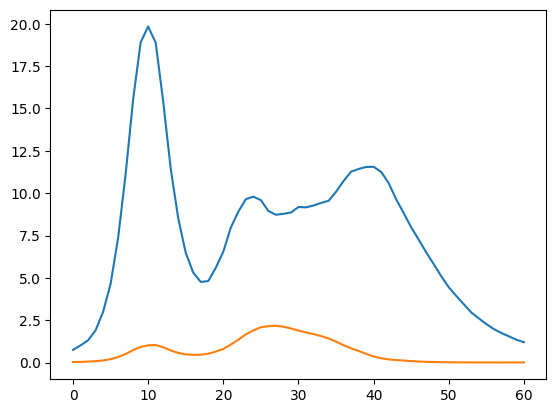

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from scipy.io import loadmat

class ReflectanceCalculator:
    def __init__(self, light_source_file, camera_sensitivity_file, munsell_file):
        # Load light source
        P_lambda_raw = pd.read_excel(light_source_file, header=None).values
        self.Lamda = np.arange(400, 705, 5)
        interp_func = interp1d(P_lambda_raw[:, 0], P_lambda_raw[:, 1], fill_value="extrapolate")
        self.P_lambda = interp_func(self.Lamda)

        # Load Munsell reflectance data
        munsell_data = loadmat(munsell_file)
        self.R_lambda = munsell_data['munsell']

        # Compute color signal
        self.C_lambda = self.P_lambda[:, np.newaxis] * self.R_lambda

        # Perform PCA once to compute the eigenspectra
        pca = PCA(n_components=3)
        pca.fit(self.C_lambda.T)
        self.eigen = pca.components_

        # Load camera sensitivity
        camera_data = np.loadtxt(camera_sensitivity_file)
        Lambda_raw = camera_data[:, 0]
        S_R_raw = camera_data[:, 1]
        S_G_raw = camera_data[:, 2]
        S_B_raw = camera_data[:, 3]

        S_R = interp1d(Lambda_raw, S_R_raw, fill_value="extrapolate")(self.Lamda)
        S_G = interp1d(Lambda_raw, S_G_raw, fill_value="extrapolate")(self.Lamda)
        S_B = interp1d(Lambda_raw, S_B_raw, fill_value="extrapolate")(self.Lamda)
        self.S_rgb = np.vstack((S_R, S_G, S_B)).T

        # Compute transformation matrix T once
        self.T = self.S_rgb.T @ self.eigen.T

    def compute_reflectance(self, RGB):
        # Step 4: Calculate reflectance for given RGB using preloaded data
        C1 = np.linalg.inv(self.T.T @ self.T)
        C2 = C1 @ self.T.T
        q = np.vstack((RGB[0], RGB[1], RGB[2]))
        a = C2 @ q

        # Reconstruct reflectance
        reflectance = self.eigen.T @ a
        return reflectance

def load_image(image_path):
        # Load image in RGB format
        image = cv2.imread(image_path)
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Example usage
RGB = [150, 120, 130]  # Example RGB values
light_source_file = file_path+'LED_Array_3.xls'
camera_sensitivity_file = file_path+'camera_8_spectra.txt'
munsell_file = file_path+'munsell400_700_5.mat'
macbeth_file = file_path+'MacbethColorChecker.xlsx'

# Create an instance of the ReflectanceCalculator
calculator = ReflectanceCalculator(light_source_file, camera_sensitivity_file, munsell_file)

# Now, you can call the compute_reflectance function multiple times without reloading data
reflectance = calculator.compute_reflectance(RGB)
#print("Computed Reflectance:", reflectance)
plt.plot(reflectance)
# Call it again with different RGB
RGB2 = [10, 20, 10]
reflectance2 = calculator.compute_reflectance(RGB2)
#print("Computed Reflectance for RGB2:", reflectance2)
plt.plot(reflectance2)



In [ ]:
import cv2
# Create an instance of the ReflectanceCalculator
calculator = ReflectanceCalculator(light_source_file, camera_sensitivity_file, munsell_file)
light_source_file = file_path+'LED_Array_3.xls'
camera_sensitivity_file = file_path+'camera_8_spectra.txt'
munsell_file = file_path+'munsell400_700_5.mat'

image1_path = file_path+'[08] Conserving a Moroccan Portrait - Before.png'
image2_path = file_path+'[08] Conserving a Moroccan Portrait - After.png'

image1 = load_image(image1_path)
height, width, _ = image1.shape
reflectance_image1 = np.zeros((height, width, 61), dtype=np.float32)

# Iterate over every pixel and compute reflectance
for i in range(image1.shape[0]):
    for j in range(image1.shape[1]):
        RGB = image1[i, j]
        reflectance_image1[i, j] = calculator.compute_reflectance(RGB).flatten()  # Use .flatten() to fix the shape

image2 = load_image(image2_path)
height, width, _ = image2.shape
reflectance_image2 = np.zeros((height, width, 61), dtype=np.float32)

# Iterate over every pixel and compute reflectance
for i in range(image2.shape[0]):
    for j in range(image2.shape[1]):
        RGB = image2[i, j]
        reflectance_image2[i, j] = calculator.compute_reflectance(RGB).flatten()  # Use .flatten() to fix the shape


In [ ]:
print(reflectance_image1.shape)
print(reflectance_image2.shape)

(1512, 1122, 61)
(1512, 1122, 61)


In [ ]:
dirt_layer = reflectance_image1 / reflectance_image2
dirt_layer.shape

(1512, 1122, 61)

In [ ]:
def to_RGB(reflectance):
    PRS_red = np.sum(P_lambda*reflectance*S_R)
    PRS_green = np.sum(P_lambda*reflectance*S_G)
    PRS_blue = np.sum(P_lambda*reflectance*S_B)

    PS_red = np.sum(P_lambda*S_R)
    PS_green = np.sum(P_lambda*S_G)
    PS_blue = np.sum(P_lambda*S_B)

    V_red  = PRS_red/PS_red
    V_green  = PRS_green/PS_green
    V_blue  = PRS_blue/PS_blue
    return [V_red*255, V_green*255, V_blue*255]

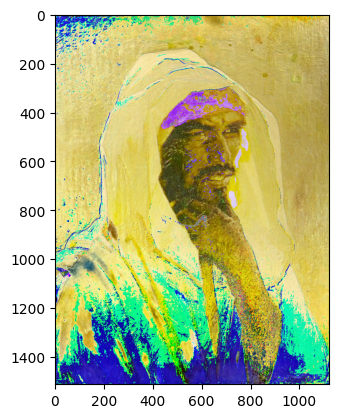

In [ ]:
# Create an empty array to store the RGB colors
color_image = np.zeros((dirt_layer.shape[0], dirt_layer.shape[1], 3), dtype=np.uint8)

# Iterate over every pixel in divided_image and convert the 61-length vector to RGB
for i in range(dirt_layer.shape[0]):
    for j in range(dirt_layer.shape[1]):
        rgb = to_RGB(dirt_layer[i, j])  # Call the to_RGB function
        color_image[i, j] = rgb  # Assign the RGB values to the color image
plt.imshow(color_image)

In [ ]:
np.sum(dirt_layer[0,0]*P_lambda*S_R)/np.sum(P_lambda*S_R)*255

9.749490210551684

In [ ]:
np.sum(P_lambda*S_R)

580852.7878294915

In [ ]:
reflectance

array([[ 0.75290409],
       [ 1.0153743 ],
       [ 1.31333714],
       [ 1.90262595],
       [ 2.99169135],
       [ 4.64773228],
       [ 7.35818886],
       [11.11973405],
       [15.54056507],
       [18.90568329],
       [19.84182756],
       [18.88563564],
       [15.41238248],
       [11.4504459 ],
       [ 8.5189207 ],
       [ 6.47541466],
       [ 5.31013541],
       [ 4.75952641],
       [ 4.81474549],
       [ 5.59915998],
       [ 6.55053057],
       [ 7.97455026],
       [ 8.91027072],
       [ 9.65026852],
       [ 9.7963822 ],
       [ 9.58652816],
       [ 8.9498026 ],
       [ 8.728603  ],
       [ 8.78255305],
       [ 8.85979005],
       [ 9.18294494],
       [ 9.16658257],
       [ 9.26906466],
       [ 9.42587205],
       [ 9.54798705],
       [10.08273659],
       [10.71974254],
       [11.27268869],
       [11.42882611],
       [11.547868  ],
       [11.55707218],
       [11.26143928],
       [10.59668111],
       [ 9.6387221 ],
       [ 8.82837373],
       [ 7

In [ ]:
import cv2  # For loading and displaying images
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from scipy.io import loadmat
import matplotlib.pyplot as plt

class ReflectanceCalculator:
    def __init__(self, light_source_file, camera_sensitivity_file, munsell_file, macbeth_file):
        # Load light source
        P_lambda_raw = pd.read_excel(light_source_file, header=None).values
        self.Lamda = np.arange(400, 705, 5)
        interp_func = interp1d(P_lambda_raw[:, 0], P_lambda_raw[:, 1], fill_value="extrapolate")
        self.P_lambda = interp_func(self.Lamda)

        # Load Munsell reflectance data
        munsell_data = loadmat(munsell_file)
        self.R_lambda = munsell_data['munsell']

        # Compute color signal
        self.C_lambda = self.P_lambda[:, np.newaxis] * self.R_lambda

        # Perform PCA once to compute the eigenspectra
        pca = PCA(n_components=2)
        pca.fit(self.C_lambda.T)
        self.eigen = pca.components_

        # Load camera sensitivity
        camera_data = np.loadtxt(camera_sensitivity_file)
        Lambda_raw = camera_data[:, 0]
        S_R_raw = camera_data[:, 1]
        S_G_raw = camera_data[:, 2]
        S_B_raw = camera_data[:, 3]

        S_R = interp1d(Lambda_raw, S_R_raw, fill_value="extrapolate")(self.Lamda)
        S_G = interp1d(Lambda_raw, S_G_raw, fill_value="extrapolate")(self.Lamda)
        S_B = interp1d(Lambda_raw, S_B_raw, fill_value="extrapolate")(self.Lamda)
        self.S_rgb = np.vstack((S_R, S_G, S_B)).T

        # Compute transformation matrix T once
        self.T = self.S_rgb.T @ self.eigen.T

        # Load Macbeth reflectance data once
        R_lambda_macbeth_raw = pd.read_excel(macbeth_file, header=None).values
        range_mask = (R_lambda_macbeth_raw[:, 0] > 399) & (R_lambda_macbeth_raw[:, 0] < 701)
        self.R_lambda_macbeth = R_lambda_macbeth_raw[range_mask, :]

        # Precompute q values for each Macbeth patch
        self.q_r, self.q_g, self.q_b = [], [], []
        for i in range(1, 25):  # Index of Macbeth patches starts at i=2
            PRS_red = self.P_lambda * self.R_lambda_macbeth[:, i] * S_R
            PRS_green = self.P_lambda * self.R_lambda_macbeth[:, i] * S_G
            PRS_blue = self.P_lambda * self.R_lambda_macbeth[:, i] * S_B
            self.q_r.append(np.sum(PRS_red))
            self.q_g.append(np.sum(PRS_green))
            self.q_b.append(np.sum(PRS_blue))

    def compute_reflectance(self, RGB):
        # Step 4: Calculate reflectance for given RGB using preloaded data
        C1 = np.linalg.inv(self.T.T @ self.T)
        C2 = C1 @ self.T.T
        q = np.vstack((RGB[0], RGB[1], RGB[2]))
        a = C2 @ q

        # Reconstruct reflectance
        reflectance = self.eigen.T @ a
        return reflectance

# New class to handle image processing
class ReflectanceImageProcessor:
    def __init__(self, reflectance_calculator):
        self.reflectance_calculator = reflectance_calculator

    def load_image(self, image_path):
        # Load image in RGB format
        image = cv2.imread(image_path)
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def compute_reflectance(self, RGB):
        # Step 4: Calculate reflectance for given RGB using preloaded data
        C1 = np.linalg.inv(self.T.T @ self.T)
        C2 = C1 @ self.T.T
        q = np.vstack((RGB[0], RGB[1], RGB[2]))
        a = C2 @ q

        # Reconstruct reflectance
        reflectance = self.eigen.T @ a  # This gives the spectral reflectance (shape 61, 1)

        # Now convert this spectral reflectance back to RGB using camera sensitivities
        R = np.sum(reflectance * self.S_rgb[:, 0])  # Red channel
        G = np.sum(reflectance * self.S_rgb[:, 1])  # Green channel
        B = np.sum(reflectance * self.S_rgb[:, 2])  # Blue channel

        return np.array([R, G, B])

    def process_images(self, image1_path, image2_path):
        # Load images
        img1_rgb = self.load_image(image1_path)
        img2_rgb = self.load_image(image2_path)

        # Compute reflectance images
        reflectance_img1 = self.compute_reflectance_image(img1_rgb)
        reflectance_img2 = self.compute_reflectance_image(img2_rgb)

        # Compute the quotient of the reflectance of image1 over image2
        quotient_reflectance = np.divide(reflectance_img1, reflectance_img2, where=reflectance_img2 != 0)

        # Convert reflectance quotient back to RGB (just for visualization)
        quotient_rgb = np.clip(quotient_reflectance * 255.0, 0, 255).astype(np.uint8)

        return quotient_rgb

    def show_image(self, image, title="Image"):
        # Display image using matplotlib
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
        plt.show()

# Example usage

# Define file paths
light_source_file = file_path+'LED_Array_3.xls'
camera_sensitivity_file = file_path+'camera_8_spectra.txt'
munsell_file = file_path+'munsell400_700_5.mat'
macbeth_file = file_path+'MacbethColorChecker.xlsx'

# Create an instance of ReflectanceCalculator
reflectance_calculator = ReflectanceCalculator(light_source_file, camera_sensitivity_file, munsell_file, macbeth_file)

# Create an instance of ReflectanceImageProcessor
image_processor = ReflectanceImageProcessor(reflectance_calculator)

# Process two images and compute their reflectance quotient
image1_path = file_path+'[08] Conserving a Moroccan Portrait - Before.png'
image2_path = file_path+'[08] Conserving a Moroccan Portrait - After.png'

result_image = image_processor.process_images(image1_path, image2_path)

# Show the resulting image
image_processor.show_image(result_image, title="Reflectance Quotient Image")


AttributeError: 'ReflectanceImageProcessor' object has no attribute 'compute_reflectance_image'